In [268]:
import glob
import numpy as np
import cv2
from skimage.feature import hog
import  matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images

In [83]:
def get_hog_features(image, orientations=9, pixels_per_cell=8, cells_per_block=2, viz=False):
    if viz:
        return hog(image[:,:,0], orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell), 
                        cells_per_block=(cells_per_block, cells_per_block), 
                        visualise=True, feature_vector=False)
    
    return hog(image[:,:,0], orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell), 
                        cells_per_block=(cells_per_block, cells_per_block), 
                        visualise=False, feature_vector=True)
        

In [101]:
def convert_color(img, cspace='LUV'):
    if cspace == 'RGB':
        return img
    if cspace == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif cspace == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif cspace == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif cspace == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return feature_image      

In [250]:
def color_histogram(img, bins=32, bins_range=(0,256)):
    channels = []
    h,w,c = img.shape
    for i in range(c):
        channel = np.histogram(img[:,:,i], bins=bins, range=bins_range)
        channels.append(channel[0])
    return np.concatenate(channels)

In [251]:
def bin_spatial(img, size=(32,32)):
    return cv2.resize(img, size).ravel()

In [259]:
def get_features(img):
    feature_image = convert_color(img)
    
    hog_features = get_hog_features(feature_image)
    spatial_features = bin_spatial(feature_image)
    color_features = color_histogram(feature_image)
    return np.concatenate((hog_features, spatial_features, color_features))

In [260]:
def load_image(img_path):
    img = cv2.imread(img_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [261]:
def extract_features(image_paths):
    features = []
    for image_path in image_paths:
        img = load_image(image_path)
        features.append(get_features(img))
    
    return features

In [262]:
cars = glob.glob('data/vehicles/*/*')
noncars = glob.glob('data/non-vehicles/*/*')

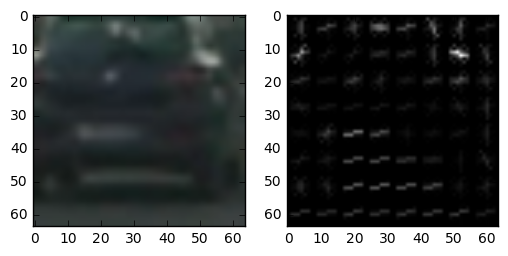

In [263]:
img = load_image(cars[0])
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img)
ax2.imshow(get_hog_features(img, viz=True)[1], cmap='gray')
plt.show()


In [266]:
car_features = extract_features(cars)
noncar_features = extract_features(noncars)
X = np.vstack((car_features, noncar_features)).astype(np.float64)
print(X.shape)

car_labels = np.ones(len(cars))
noncar_labels = np.zeros(len(noncars))
y = np.hstack((car_labels, noncar_labels))
print(y.shape)


(17760, 4932)
(17760,)


In [267]:
scaler_1 = StandardScaler().fit(X)
X_scaled = scaler_1.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [270]:
import time
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

acc = svc.score(X_test, y_test)
print('Accuracy', acc)

Accuracy 0.983671171171


In [283]:
def draw_boxes(img, bboxes):
    res = np.copy(img)
    for top, bottom in bboxes:
        cv2.rectangle(res, top, bottom, color=(0,0,255), thickness=6)
    return res

In [284]:
def get_windows(img, y_start_stop, window_size=64, overlap=0.5):
    h,w,c = img.shape
    xspan = w
    yspan = y_start_stop[1] - y_start_stop[0]
    
    step = int(window_size * overlap)
    x_windows = xspan//step - 1
    y_windows = yspan//step - 1
    
    windows = []
    for y in range(y_windows):
        for x in range(x_windows):
            top_x = x*step
            top_y = y*step
            bottom_x = top_x + window_size
            bottom_y = top_y + window_size
            windows.append(((top_x, top_y), (bottom_x, bottom_y)))
    
    return windows

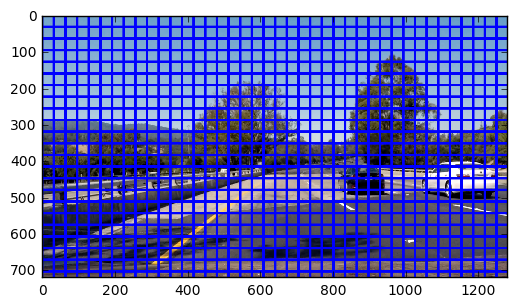

In [288]:
test_image = load_image('test_images/test4.jpg')

windows = get_windows(test_image, y_start_stop=(0,960))
res = draw_boxes(test_image, windows)

plt.imshow(res)
plt.show()
